Best viewed locally in a Jupyter notebook or online in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics/blob/master/analysis.ipynb">Jupyter Notebook Viewer</a>

# Analysis of Noun Semantics in the Hebrew Bible
## Cody Kingham

In this notebook, I compare the syntactic contexts of the top 200 most frequent nouns in the Hebrew Bible. This notebook essentially walks through my process and includes limited commentary throughout. Full descriptions borrowed from the paper will soon be transferred to here as well.

In [64]:
! echo "last updated:"; date

last updated:
Fri 29 May 2020 12:27:00 BST


In [2]:
from pathlib import Path

# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.app import use

# stats & data-containers
import collections, math, re, random, csv
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from kneed import KneeLocator # https://github.com/arvkevi/kneed

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['Times New Roman']

from IPython.display import HTML, display, Image
from adjustText import adjust_text # fixes overlapping scatterplot annotations

# custom modules
from pyscripts.contextparameters import deliver_params
from pyscripts.deliver_data import deliver_data
from pyscripts.pca import apply_pca
import pyscripts.significance as my_stats
#from pyscripts import feature_formatting

# prep the Hebrew syntax data
name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'heads', 'phono')] # data dirs
load_features = '''
typ phono lex_utf8 lex
voc_lex_utf8 voc_lex gloss
freq_lex pdp sp ls
language
rela number function
vs vt
code label

head obj_prep sem_set nhead
heads noun_heads
''' 

# Text Fabric load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = use('bhsa', api=api, hoist=globals(), silent=True) # Bhsa functions for search and visualizing text

This is Text-Fabric 8.1.2
Api reference : https://annotation.github.io/text-fabric/cheatsheet.html

124 features found and 0 ignored
  0.00s loading features ...
   |     0.00s Dataset without structure sections in otext:no structure functions in the T-API
  9.39s All features loaded/computed - for details use loadLog()


In [63]:
# configure paths for figures and data
plot_path = Path('results/plots/')
table_path = Path('results/tables')
fisher_data = table_path.joinpath('fisher_scores.csv')

def savefig(name):
    plt.savefig(plot_path.joinpath(name), format='svg', bbox_inches='tight')
def savecsv(name, df):
    df.to_csv(table_path.joinpath(name))

In [4]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, joiner='&nbsp;&nbsp;|', title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = joiner.join(T.text(node) for node in word_nodes)
    display(HTML(formatted))
    
def show_subphrases(phrase, direction=L.d):
    '''
    A simple function to print subphrases
    and their relations to each other.
    '''
    for sp in direction(phrase, 'subphrase'):
        
        mother = E.mother.f(sp)[0] if E.mother.f(sp) else ''
        mother_text = T.text(mother)
        
        print('-'*7 + str(sp) + '-'*16)
        print()
        print(f'{T.text(sp)} -{F.rela.v(sp)}-> {mother_text}')
        print(f'nodes:  {sp} -{F.rela.v(sp)}-> {mother}')
        print(f'slots:  {L.d(sp, "word")} -{F.rela.v(sp)}-> {L.d(mother or 0, "word")}')
        print('-'*30)

## Corpus Size

Below is the number of words included in the corpus of BHSA.

In [5]:
len(list(F.otype.s('word')))

426584

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [6]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.03s 3706 results


Now we order the results on the basis of lexeme frequency.

In [7]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [8]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.displaySetup(extraFeatures={'ls', 'freq_lex'}) # config B to display ls and freq_lex

# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    print(T.text(node), end=' | ')

כֹּל  | בֵּן  | אֱלֹהִים  | מֶלֶךְ  | אֶרֶץ  | יֹום  | אִישׁ  | פָּנֶה  | בַּיִת  | עַם  | יָד  | דָּבָר  | אָב  | עִיר  | אֶחָד  | עַיִן  | שָׁנָה  | שֵׁם  | עֶבֶד  | אַיִן  | אִשָּׁה  | שְׁנַיִם  | נֶפֶשׁ  | כֹּהֵן  | אַחַר  | דֶּרֶךְ  | אָח  | שָׁלֹשׁ  | לֵב  | רֹאשׁ  | בַּת  | מַיִם  | מֵאָה  | הַר  | גֹּוי  | אָדָם  | חָמֵשׁ  | קֹול  | תַּחַת  | פֶּה  | אֶלֶף  | עֹוד  | שֶׁבַע  | צָבָא  | קֹדֶשׁ  | אַרְבַּע  | עֹולָם  | מִשְׁפָּט  | שַׂר  | שָׁמַיִם  | 

Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [9]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.03s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

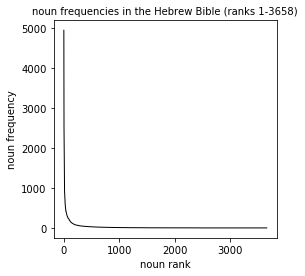

In [10]:
# plot data
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]
title = 'noun frequencies in the Hebrew Bible'
xlabel = 'noun rank'
ylabel = 'noun frequency'

# first plot
plt.figure(figsize=(4, 4))
plt.plot(x_rank, y_freqs, color='black', linewidth=1)
plt.title(title + f' (ranks 1-{len(x_rank)})', size=10)
plt.xlabel(xlabel, size=10)
plt.ylabel(ylabel, size=10)
plt.plot()
plt.show()

We zoom in closer to view ranks 1-1000...

*Consider using a subplot here with 4 different zooms*

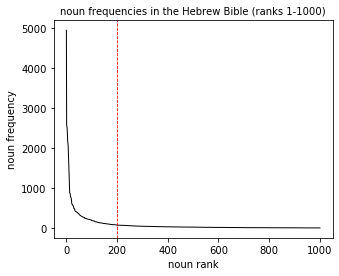

In [11]:
# second plot
plt.figure(figsize=(5, 4))
plt.plot(x_rank[:1000], y_freqs[:1000], color='black', linewidth=1)
plt.xlabel(xlabel, size=10)
plt.ylabel(ylabel, size=10)
plt.axvline(200, color='red', linewidth=0.8, linestyle='--')
savefig('noun_frequencies1-1000.svg')
plt.title(title + f' (ranks 1-1000)', size=10)
plt.show()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [12]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


In [13]:
nouns_text_freqs = sorted(
    ((F.voc_lex_utf8.v(L.d(noun,'word')[0]), F.freq_lex.v(noun)) 
         for noun in target_nouns), key=lambda k: k[-1], reverse=True
)

In [14]:
', '.join(f'{noun}' for noun, freq in nouns_text_freqs)

'בֵּן, אֱלֹהִים, מֶלֶךְ, אֶרֶץ, יֹום, אִישׁ, פָּנֶה, בַּיִת, עַם, יָד, דָּבָר, אָב, עִיר, עַיִן, שָׁנָה, שֵׁם, עֶבֶד, אִשָּׁה, נֶפֶשׁ, כֹּהֵן, דֶּרֶךְ, אָח, לֵב, רֹאשׁ, בַּת, מַיִם, הַר, גֹּוי, אָדָם, קֹול, פֶּה, עֹוד, צָבָא, קֹדֶשׁ, עֹולָם, מִשְׁפָּט, שַׂר, שָׁמַיִם, תָּוֶךְ, חֶרֶב, כֶּסֶף, מִזְבֵּחַ, מָקֹום, יָם, זָהָב, אֵשׁ, רוּחַ, נְאֻם, שַׁעַר, דָּם, אֹהֶל, סָבִיב, אָדֹון, עֵץ, כְּלִי, שָׂדֶה, נָבִיא, רָעָה, מִלְחָמָה, מְאֹד, לֶחֶם, עֵת, חַטָּאת, עֹלָה, חֹדֶשׁ, בְּרִית, אַף, פַּרְעֹה, צֹאן, אֶבֶן, מִדְבָּר, בָּשָׂר, מַטֶּה, לֵבָב, רֶגֶל, אַמָּה, חֶסֶד, חַיִל, נַעַר, גְּבוּל, שָׁלֹום, אֵל, מַעֲשֶׂה, עָוֹן, זֶרַע, קֶרֶב, לַיְלָה, בַּד, נַחֲלָה, אֲדָמָה, מֹועֵד, תֹּורָה, אֵם, בֶּגֶד, מַחֲנֶה, בֹּקֶר, מַלְאָךְ, מִנְחָה, אֲרֹון, כָּבֹוד, חָצֵר, כַּף, שֶׁמֶן, שֵׁבֶט, בְּהֵמָה, מִשְׁפָּחָה, אֹזֶן, רֵעַ, סֵפֶר, בָּקָר, מִצְוָה, שָׂפָה, דֹּור, בַּעַל, חוּץ, פֶּתַח, אַיִל, זֶבַח, מָוֶת, גִּבֹּור, צְדָקָה, רֹב, צָפֹון, חָכְמָה, עֵדָה, חַיִּים, עֲבֹדָה, יַיִן, מַעַל, מִשְׁכָּן, נַחַל, יָמִין,

## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. 

In [15]:
contexts = deliver_params(tnoun_instances, tf=api)
print('done!')

done!


In [16]:
data = deliver_data(contexts, tf=TF)

running query on template [ T.function→ st.verb.lex ]...
	19884 results found.
running query on template [ T.prep.funct→ st.verb.lex ]...
	15009 results found.
running query on template [ lex.PreC→ T.Subj ]...
	2525 results found.
running query on template [ lex.prep.PreC→ T.Subj ]...
	1136 results found.
running query on template [ T.PreC→ lex.Subj ]...
	930 results found.
running query on template [ T.prep.PreC→ lex.Subj ]...
	1504 results found.
running query on template [ lex.coord→ T ]...
	4217 results found.
running query on template [ T.coord→ lex ]...
	4336 results found.
running query on template [ lex.atr→ T ]...
	1588 results found.
running query on template [ lex.coord→ T (phrase atoms) ]...
	704 results found.
running query on template [ T.coord→ lex (phrase atoms) ]...
	600 results found.
running query on template [ lex.appo→ T ]...
	1410 results found.
running query on template [ T.appo→ lex ]...
	3640 results found.


Let's have a look at the first example...

In [17]:
data[0]

{'clause': 427553,
 'book': 'Gen',
 'ref': 'Gen 1:1',
 'clause_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'target': 'אלהים.n1',
 'target_node': 4,
 'basis': 'T.Subj→ ברא.v1.qal',
 'basis_nodes': (3, 651544),
 'verse_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'context_type': 'T.function→ st.verb.lex',
 'function': 'Subj'}

Now we put the data into a dataframe. We also export the dataframe for reference.

In [18]:
data_df = pd.DataFrame(data)
data_df.set_index('clause', inplace=True)
data_df.to_csv('dataset.csv') # export dataset
data_df.head()

,book,ref,clause_text,target,target_node,basis,basis_nodes,verse_text,context_type,function
clause,,,,,,,,,,
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,אלהים.n1,4,T.Subj→ ברא.v1.qal,"(3, 651544)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Subj
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,שׁמים.n1,7,T.Objc→ ברא.v1.qal,"(3, 651545)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Objc
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,ארץ.n1,11,T.Objc→ ברא.v1.qal,"(3, 651545)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Objc
427557,Gen,Gen 1:3,וַיֹּ֥אמֶר אֱלֹהִ֖ים,אלהים.n1,34,T.Subj→ אמר.v1.qal,"(33, 651559)",וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י אֹ֑ור וַֽיְהִי־אֹֽ...,T.function→ st.verb.lex,Subj
427560,Gen,Gen 1:4,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור,אלהים.n1,42,T.Subj→ ראה.v1.qal,"(41, 651567)",וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור כִּי־טֹ֑וב וַי...,T.function→ st.verb.lex,Subj


Now we'll build the co-occurrence counts.

In [19]:
raw_counts = pd.pivot_table(
    data_df, 
    index='target', 
    columns='basis', 
    fill_value=0,
    aggfunc='size'
)

# sort by size, first by noun sum, then by basis sum
raw_counts = raw_counts.loc[raw_counts.sum(1).sort_values(ascending=False).index]
raw_counts = raw_counts[raw_counts.sum().sort_values(ascending=False).index]

raw_counts.head()

basis,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.coord→ בן.n1,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.ל.Cmpl→ שׁנן.v2.piel,T.ל.Cmpl→ שׁמע.v1.piel,T.ל.Cmpl→ שׁמע.v1.nif,T.ל.Cmpl→ שׁלך.v1.hof,T.ל.Cmpl→ שׁכן.v1.hif,T.ל.Cmpl→ שׁיח.v1.qal,T.ל.Cmpl→ שׁחח.v1.qal,T.ל.Cmpl→ שׁור.v2.qal,T.ל.Cmpl→ שׁוב.v2.qal,T.Adju→ אכל.v1.pual
target,,,,,,,,,,,,,,,,,,,,,
בן.n1,0,15,1,23,24,34,144,32,4,2,...,1,0,0,0,0,0,0,0,0,0
מלך.n1,2,10,0,1,127,28,0,13,0,5,...,0,0,1,0,0,0,0,1,0,0
ארץ.n1,0,61,11,8,1,2,0,1,0,5,...,0,0,0,1,0,0,0,0,0,0
אלהים.n1,730,4,9,1,50,8,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
אישׁ.n1,0,6,1,24,42,34,1,14,0,1,...,0,0,0,0,0,0,0,0,0,0


## Removing Outliers

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. The resulting p-values, of which <0.05 represents a statistically significant colexeme, will be log-transformed. Values that fall below expected frequencies will be negatively transformed.

In [20]:
raw_counts.sum(1).sort_values().head(10)

target
נאם.n1       7
פאה.n1      25
מספר.n1     29
רב.n2       29
קדם.n1      37
מעל.n1      40
שׁקר.n1     43
תמיד.n1     43
מלכות.n1    43
עבר.n1      45
dtype: int64

We note that the term נאם only occurs 7 times in the entire dataset<br>
compared with the other terms. We will therefore drop that term due to<br>
a lack of representative examples.

### Remove Co-occurrence Outliers

We will remove colexemes/bases that occur with only one target noun. This is done by subtracting<br> 
the row total from each item in the row. Any 0 value in a row means that that row has a unique <br>
colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will<br>
remove these rows further down.

### Drop the outliers

In [21]:
# drop נאם and any context counts left empty as a result
count_df = raw_counts.drop('נאם.n1', axis=0)
empties = count_df.loc[:, (count_df == 0).all(0)]
count_df = count_df.drop(empties.columns, axis=1)

# drop all hapax legomena
colex_counts = count_df.sum(0)
remaining_counts = count_df.sub(colex_counts, axis=1) # subtract colex_counts
hapax_colex = remaining_counts.loc[:,(remaining_counts == 0).any(0)] # select columns that have a 0 value anywhere
count_df = count_df.drop(labels=hapax_colex.columns, axis=1)

print(f'New data dimensions: {count_df.shape}')
print(f'New total observations: {count_df.sum().sum()}')
print(f'Observations removed: {raw_counts.sum().sum() - count_df.sum().sum()}')

New data dimensions: (199, 4181)
New total observations: 44886
Observations removed: 12597


Let's look at the sorted minimum values to make sure no terms have been left featureless.

In [23]:
count_df.sum().sort_values().head(5)

basis
T.Subj→ כתת.v1.hof        2
T.ל.PreC→ גאון.n1.Subj    2
T.ל.PreC→ אחד.n1.Subj     2
T.coord→ חמאה.n1          2
T.appo→ אברם.n1           2
dtype: int64

In [24]:
count_df.sum(1).sort_values().head(5)

target
פאה.n1     18
מספר.n1    18
שׁקל.n1    18
מעל.n1     20
רב.n2      21
dtype: int64

### How many zero counts are there?

The raw count matrix has a lot of sparsity. Here's how many zeros there are. We also count other values.

In [25]:
# unique_values, value_counts = np.unique(data.values, return_counts=True)
# unique_counts = pd.DataFrame.from_dict(dict(zip(unique_values, value_counts)), orient='index', columns=['count'])
# display(HTML('<h5>Top 10 Unique Values and Their Counts in Dataset</h5>'))
# unique_counts.head(10)

In [26]:
# zero = unique_counts.loc[0.0][0]
# non_zero = unique_counts[unique_counts.index > 0].sum()[0]
# non_zero_ratio, zero_ratio = non_zero / (non_zero+zero), zero / (non_zero+zero)

# print(f'Number of zero count variables: {zero} ({round(zero_ratio, 2)})')
# print(f'Number of non-zero count variables: {non_zero} ({round(non_zero_ratio, 2)})')

Below the number of observed counts is given:

In [27]:
count_df.sum().sum()

44886

## Data Distribution

The basic unit of analysis is the level of the clause. We have selected a <br>
subset of all clauses from the Hebrew Bible. Let's see if the observed <br>
frequencies within the dataset exist above or below the expected frequencies.<br>
If they are below, then how much so?

In [28]:
from pyscripts.feature_formatting import book2sbl

In [29]:
all_clauses = collections.Counter()
for cl in F.otype.s('clause'):
    lang = F.language.v(L.d(cl,'word')[0])
    if lang != 'Hebrew':
        continue
    book, chapter, verse = T.sectionFromNode(cl)
    book = book2sbl[book]
    all_clauses[book] += 1
expected_freq = pd.Series(all_clauses)
expected_freq.head()

Gen     5987
Exod    4326
Lev     3077
Num     3925
Deut    3859
dtype: int64

In [30]:
# get samples from dataset
sample_df = data_df.loc[
    (data_df.target.isin(count_df.index)) & (data_df.basis.isin(count_df.columns))
]

In [31]:
# calculate deviation of proportions (Gries 2008; Levshina 2015)
# for observed frequencies, we only want to consider each clause once
# thus we create a dataframe that only keeps the first clause entry
non_duplicated_clauses = sample_df[~sample_df.index.duplicated(keep='first')]
observed_freq = non_duplicated_clauses.book.value_counts()
observed_prop = observed_freq.div(observed_freq.sum())
expected_prop = expected_freq.div(expected_freq.sum())
deviation_prop = observed_prop - expected_prop

Let's compare the overall number of clauses with observed clauses.

In [32]:
# overall clauses
expected_freq.sum()

86828

In [33]:
# observed clauses
observed_freq.sum()

28226

Let's make that a proportion...

In [34]:
observed_freq.sum() / expected_freq.sum()

0.3250794674528954

We see that our dataset consists of 32% of all clauses in the Hebrew Bible. This raises the<br>
further question. Have any particular books become over/under represented in the sample?<br>
We can answer this question by calculating the deviation of proportions (above), which tells<br>
how much the observed proportions differ from the expected proportions.<br>

In this case, let total number of clauses in the Hebrew Bible be $NC$ and let the total number<br>
of clauses in the sample be $SC$. We can obtain the deviation of proportions by doing the following:

[add formula]

### Plot Book Representations in Sample

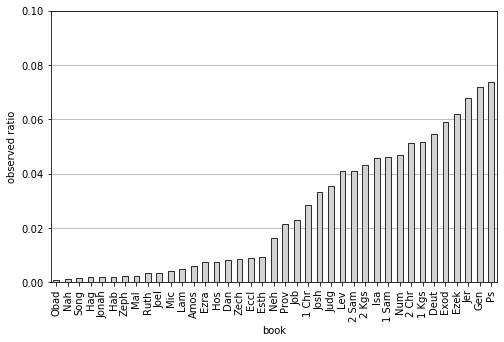

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

observed_prop.sort_values().plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylim((0, 0.1))
ax.set_ylabel('observed ratio')
ax.set_xlabel('book')

savefig('sample_book_proportions.svg')

### Plot deviated proportions in sample from expected proportion (entire Hebrew Bible)


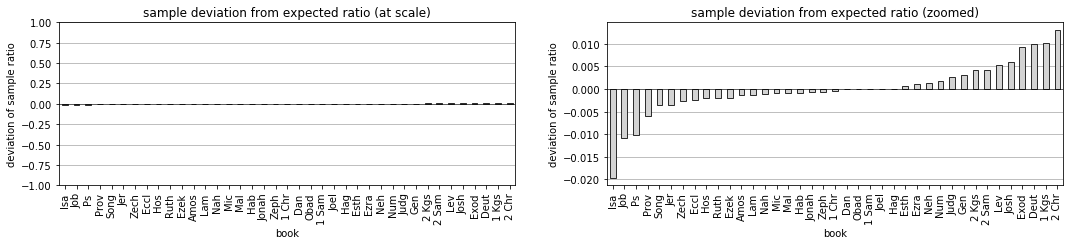

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 3))

for ax in (ax1, ax2):
    deviation_prop.sort_values().plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel('deviation of sample ratio')
    ax.set_xlabel('book')
    
ax1.set_title('sample deviation from expected ratio (at scale)')
ax1.set_ylim((-1, 1))
ax2.set_title('sample deviation from expected ratio (zoomed)')

savefig('sample_deviation_proportions.svg')

In [37]:
deviation_prop.sort_values().head(10)

Isa    -0.019663
Job    -0.010938
Ps     -0.010093
Prov   -0.006010
Song   -0.003516
Jer    -0.003439
Zech   -0.002663
Eccl   -0.002424
Hos    -0.002096
Ruth   -0.002038
dtype: float64

In [38]:
deviation_prop.sort_values(ascending=False).head(10)

2 Chr    0.013134
1 Kgs    0.010098
Deut     0.009974
Exod     0.009307
Josh     0.006054
Lev      0.005411
2 Sam    0.004238
2 Kgs    0.004100
Gen      0.003073
Judg     0.002651
dtype: float64

Here we see 2% underpresentation of Isaiah, as well as some smaller representation<br>
of Psalms, Job, and Proverbs.

In general, the underepresented portions are more poetic/prophetic in nature while more<br>
narratival books are represented very slightly higher.

Meanwhile there is a slightly higher sample of 2 Chronicles (1.3%) 1 Kings (1%) and Deuteronomy<br>
(1%).

These differences are very small, and thus we can say that the sample dataset is essentially as<br>
evenly distributed as the original sample across the Hebrew Bible.

## Context Type Distribution

Looking at the distribution of the various contexts

In [40]:
context_counts = sample_df.context_type.value_counts()
context_props = context_counts.div(context_counts.sum())

context_counts

T.function→ st.verb.lex        17539
T.prep.funct→ st.verb.lex      11216
T.coord→ lex                    3681
lex.coord→ T                    3564
T.appo→ lex                     2557
lex.PreC→ T.Subj                1330
lex.atr→ T                      1297
lex.appo→ T                      961
lex.coord→ T (phrase atoms)      616
T.prep.PreC→ lex.Subj            569
lex.prep.PreC→ T.Subj            540
T.coord→ lex (phrase atoms)      526
T.PreC→ lex.Subj                 490
Name: context_type, dtype: int64

In [41]:
context_props

T.function→ st.verb.lex        0.390745
T.prep.funct→ st.verb.lex      0.249877
T.coord→ lex                   0.082008
lex.coord→ T                   0.079401
T.appo→ lex                    0.056967
lex.PreC→ T.Subj               0.029631
lex.atr→ T                     0.028895
lex.appo→ T                    0.021410
lex.coord→ T (phrase atoms)    0.013724
T.prep.PreC→ lex.Subj          0.012677
lex.prep.PreC→ T.Subj          0.012030
T.coord→ lex (phrase atoms)    0.011719
T.PreC→ lex.Subj               0.010917
Name: context_type, dtype: float64

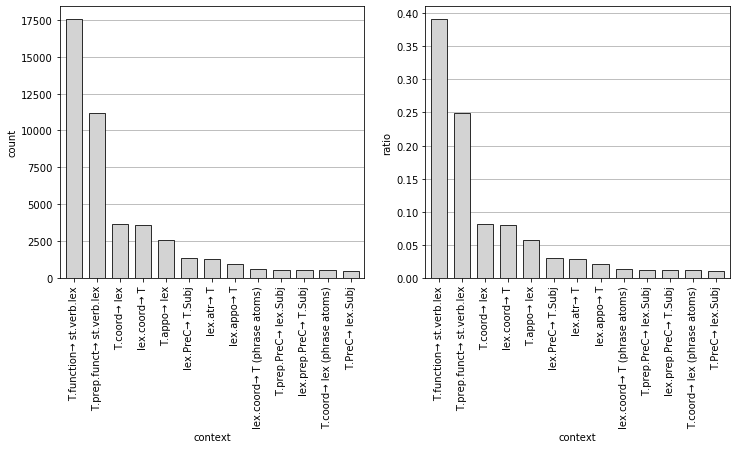

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for ax, data in zip((ax1, ax2), (context_counts, context_props)):
    data.plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8, width=0.7)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('context')
    
ax1.set_ylabel('count')
ax2.set_ylabel('ratio')

savefig('context_counts.svg')

### Look at function distribution

In [44]:
function_count = sample_df.function.value_counts()
function_prop = function_count.div(function_count.sum())

function_count

Objc    9986
Cmpl    8328
Subj    6350
Adju    2104
Time    1188
Loca     536
Modi     248
PrAd      15
Name: function, dtype: int64

In [45]:
function_prop

Objc    0.347279
Cmpl    0.289619
Subj    0.220831
Adju    0.073170
Time    0.041315
Loca    0.018640
Modi    0.008625
PrAd    0.000522
Name: function, dtype: float64

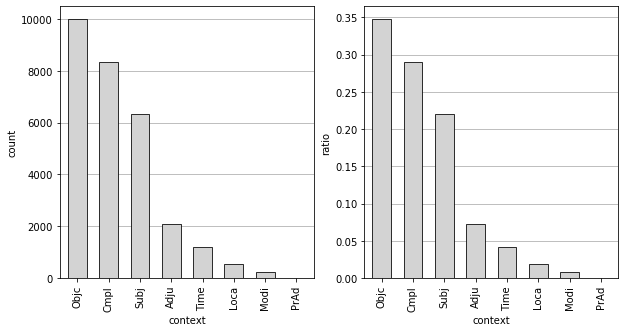

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for ax, data in zip((ax1, ax2), (function_count, function_prop)):
    data.plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8, width=0.6)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('context')
    
ax1.set_ylabel('count')
ax2.set_ylabel('ratio')
savefig('function_counts.svg')

<hr>

#### Examining the Dataset

Below we look at the number of dimensions in the data:

In [51]:
count_df.shape

(199, 4181)

And number of observations..

In [50]:
count_df.size

832019

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

#### Number of Datapoints To Iterate Over

The Fisher's exact test takes some time to run. That is because it must iterate over a lot of pairs. The number is printed below.

In [54]:
count_df.size

832019

#### Apply the Tests

The whole run takes 5.5-6.0 minutes on a 2017 Macbook pro.

In [57]:
run = True

if run:
    fisherdata, odds_ratios = my_stats.apply_fishers(count_df, sample_axis=0, feature_axis=1)
    fisherdata.to_csv(fisher_data)
else:
    fisherdata = pd.read_csv(fisher_data)

In [58]:
fisherdata.head(10)

,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.coord→ בן.n1,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.על.Cmpl→ כבד.v1.qal,T.Subj→ כלם.v1.hif,חרפה.n1.coord→ T,רך.n1.PreC→ T.Subj,חרץ.v1.PreC→ T.Subj,חתם.v1.PreC→ T.Subj,T.עד.Time→ עמד.v1.hif,T.Objc→ שׁלם.v1.hif,T.Objc→ שׁלל.v1.qal,T.Subj→ כתת.v1.hof
בן.n1,-22.506257,-6.579793,-16.256213,-0.732143,-0.530153,1.123235,74.015168,1.963515,-4.088860,-5.296022,...,0.000000,0.0,0.879459,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
מלך.n1,-8.701775,-2.451740,-8.926695,-5.459739,78.217023,3.860716,-5.200123,0.370243,-3.806548,-0.635022,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ארץ.n1,-10.056006,13.048434,-1.126735,-0.989002,-4.605041,-2.867567,-4.681587,-2.875867,-3.480049,-0.431153,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
אלהים.n1,inf,-5.766333,-2.196198,-5.458588,12.373411,-0.702152,-5.197390,-1.411536,-4.015970,-1.995487,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
אישׁ.n1,-10.269249,-3.725940,-6.745259,1.865083,9.407068,7.438862,-3.500331,0.862503,-3.471931,-2.405216,...,1.200033,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
יום.n1,-7.020936,-4.940696,-2.175071,-3.948764,-3.969073,1.332199,-3.137104,-2.627612,-2.269489,-2.295491,...,0.000000,0.0,0.000000,0.0,1.358093,0.0,0.0,0.0,0.0,0.0
עם.n1,-10.444091,-1.131409,-8.236013,-2.173010,4.532914,2.579546,-2.225901,0.732160,-1.843644,-1.278042,...,1.194137,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
בית.n1,-8.853672,-0.820445,-0.503091,-3.330368,-2.487866,-1.409670,-1.150665,0.138360,-3.152582,-1.421100,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
פנה.n1,-7.018551,-0.374947,-5.495001,-4.152851,-3.963040,-3.303389,-3.134563,24.286097,6.657481,7.614609,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
יד.n1,-8.211783,-0.769171,-6.311712,-4.834211,-4.634769,-2.869457,-3.633232,-3.144858,5.589620,1.328457,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


The Fisher's test has produced p-vales of 0, indicating a very high degree of attraction between lexemes and a colexemes. A log-transformed zero equals `infinity`. Below those values are isolated.

In [59]:
display(HTML('<h5>contexts x nouns with a p-value of 0 :</h5>'))
inf_nouns = fishertransf.columns[(fishertransf == np.inf).any()]
inf_data = [] # inf data contains column/index information needed to assign the new values
for inf_noun in inf_nouns:
    inf_noun2context = pd.DataFrame(fishertransf[inf_noun][fishertransf[inf_noun] == np.inf])
    inf_data.append(inf_noun2context)
    display(inf_noun2context)

In this case the Fisher's has returned a zero value. A p-value of 0 means that the likelihood אלהים and יהוה are *not* dependent variables is essentially null. We can thus reject the null hypothesis that the two values are not related. There is, rather, a maximum level of confidence that these two values *are* interrelated. The `np.inf` value that resulted from `log10(0)` is not viable for calculating vector distances. Thus, we need to substitute an arbitrary, but appropriate value. Below we access the lowest non-zero p-values in the dataset.

In [ ]:
minimum_pvalues = fisherdata.min()[fisherdata.min() > 0].sort_values()
minmin_noun = minimum_pvalues.index[0]
minmin_context = fisherdata[minimum_pvalues.index[0]].sort_values().index[0]
minimum_pvalues.head(10)

The minimum noun x context score is shown below.

In [ ]:
minmin_noun

In [ ]:
minmin_context

The small pvalue listed above is used to substitute the infinitive values below.

In [ ]:
# make the substitutions 
for inf_dat in inf_data:
    for noun in inf_dat.columns:
        for context in inf_dat.index:
            print(f'adjusting infinite score for {noun}')
            new_pvalue, new_transf = fisherdata[minmin_noun][minmin_context], fishertransf[minmin_noun][minmin_context]
            fisherdata[noun][context] = new_pvalue
            print(f'\tpvalue updated to {new_pvalue}')
            fishertransf[noun][context] = new_transf
            print(f'\ttransformed pvalue updated to {new_transf}')

Below we double to check to ensure that all infinitive values have been removed. The test should read `False`.

In [ ]:
# infinites in dataset?
bool(len(fishertransf[(fishertransf == np.inf).any(1)].index))

### Comparing Raw and Adjusted Counts

What kinds of counts are "upvoted" and "downvoted" in the adjusted numbers? This information is helpful for gaining insight into the adjustment process and the efficacy of its results.

Below I isolate and compare counts for a set of key lexemes: מלך "king", עיר "city", and חכמה "wisdom". The counts are analyzed by comparing context tag rankings and looking for those contexts which are most affected (i.e. have the most absolute differences) by the changes. 

In [ ]:
examine_nouns = ['מלך.n1', 'עיר.n1', 'חכמה.n1']

context_rankings = {}

# gather context rankings into dataframes
for noun in examine_nouns:
    
    # make raw context DF, sorted, with columns count and rank
    rawcounts = pd.DataFrame(data[noun].values, 
                             columns=['count'], 
                             index=data.index).sort_values(ascending=False, by='count')
    rawcounts['rank'] = np.arange(len(rawcounts))+1 # add column "rank"
    
    # make adjusted context DF, sorted, with columns count and rank
    adjcounts = pd.DataFrame(fishertransf[noun].values, 
                             columns=['count'], 
                             index=fishertransf.index).sort_values(ascending=False, by='count')
    adjcounts['rank'] = np.arange(len(adjcounts))+1
    
    # put both DFs into dict mapped to noun
    context_rankings[noun]={'raw':rawcounts, 'adj':adjcounts}
    
    
# print for each noun a report on top up/downgrades
for noun, rankset in context_rankings.items():
    raw, adj = rankset['raw'], rankset['adj']
    upgrades = pd.DataFrame((raw['rank']-adj['rank']).sort_values(ascending=False))
    downgrades = pd.DataFrame((raw['rank']-adj['rank']).sort_values())
    upgrades.columns, downgrades.columns = [['difference']]*2
    upgrades['previous rank'], downgrades['previous rank'] = [raw['rank']]*2
    upgrades['new rank'], downgrades['new rank'] = [adj['rank']]*2

    display(HTML(f'<h3>{noun}</h3>'))
    print('top 10 raw counts:')
    display(raw.head(10))
    print('top 10 adjusted counts:')
    display(adj.head(10))
    print('top 10 rank upgrades')
    display(upgrades.head(10))
    print('top 10 rank downgrades')
    display(downgrades.head(10))
    print('-'*40)
    print()

#### Export Data for מלך for Paper

In [ ]:
context_rankings['מלך.n1']['raw'].head(10).to_csv('spreadsheets/king_top10_raw.csv')
round(context_rankings['מלך.n1']['adj'].head(10), 2).to_csv('spreadsheets/king_top10_adj.csv')

#### Extracting Specific Examples for the Paper (on מלך) to Illustrate Count Adjustments

Below the four separate parts of the contingency table are extracted for מלך "king". These were previously calculated above 

In [ ]:
data['מלך.n1']['T.Objc→ נתן.v1.qal'] # A

In [ ]:
b_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # B

In [ ]:
c_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # C

In [ ]:
d_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # D

Where do the 10 cases happen?

In [ ]:
passages = []
for res in counts.target2basis2result['מלך.n1']['T.Objc→ נתן.v1.qal']:
    passages.append('{} {}:{}'.format(*T.sectionFromNode(res[0])))
print('; '.join(passages))

What is the result of the Fisher's test?

In [ ]:
round(fisherdata['מלך.n1']['T.Objc→ נתן.v1.qal'], 4)

What is the value of the expected count?

In [ ]:
round(expectedfreqs['מלך.n1']['T.Objc→ נתן.v1.qal'], 2)

In [ ]:
round(fishertransf['מלך.n1']['T.Objc→ נתן.v1.qal'], 2)

How has the rank changed?

In [ ]:
context_rankings['מלך.n1']['raw'].loc['T.Objc→ נתן.v1.qal']

In [ ]:
context_rankings['מלך.n1']['adj'].loc['T.Objc→ נתן.v1.qal']

<hr>

#### Excursus: A Random Sample Examined

We saw that the model seems to be succeeding at isolating intuitive associations with קול. Let's look at another example at random, in this case the noun ארץ ("land"). Below are the transformed p-values for that noun.

In [ ]:
fishertransf['ארץ.n1'].sort_values(ascending=False).head(10)

The most associated variables include cases where ארץ is an object to the verb ירשׁ, where ארץ serves as the complement from which something is brought (hifil of יצא and hifil of עלה), frequently in construct to עם "people"), the participle of ישב "inhabitant(s)"), and ממלכה, "kingdom", as well as other satisfying and expected occasions of use. These examples show that the model is working well.
<hr>

## Comparing the Nouns

The nouns are now ready to be compared. I will do so in two ways.

1. Principle Component Analysis — We have a semantic space with 4,218 dimensions. That is a lot of potential angles from which to compare the vectors. One method that is commonly used in semantic space analysis is principle component analysis or **PCA**. PCA is a dimensionality reduction method that reduce a multi-dimensional vector to the two points in an imagined space that show the most distance between the nouns. We can visualize said space by plotting the two points on an X and Y axis.
2. Cosine Similarity — This measure allows us to compare the vectors on the basis of their trajectories. This method is particularly well-suited for semantic spaces because it ignores differences in frequency and compares, rather, the closeness of relationship between two sets of frequencies. 

### PCA Analysis

We want to apply PCA in order to plot nouns in an imaginary space. The goal is to use the visualization to identify patterns and groups amongst the 199 target nouns. Nouns that are more similar should fall within the same general areas relative to the origin (0, 0). PCA seeks to identify the maximum variance amongst the vector spaces. 

In [ ]:
pca = PCA(10) # PCA with 3 principal components
noun_fit = pca.fit(fishertransf.T.values) # get coordinates
pca_nouns = noun_fit.transform(fishertransf.T.values)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=noun_fit.explained_variance_ratio_[:10])
plt.xlabel('Principle Component', size=20)
plt.ylabel('Raio of Explained Variance', size=20)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=20)
plt.show()

Variance accounted for by PC1 and PC2:

In [ ]:
noun_fit.explained_variance_ratio_[0]+noun_fit.explained_variance_ratio_[1]

The plot above, also called a scree plot, tells us that the first two principle components only account for 12% of the total variance in the dataset. Thus the PCA noun space is rather noisy. This may be explained by the fact that we are combining many different kinds of syntactic contexts into one dataset. And it may also be due to the rather spread out nature of lexical data. 

Below we extract the top 25 features which are most influential for the first two principal components.

In [ ]:
loadings = noun_fit.components_.T * np.sqrt(noun_fit.explained_variance_)
loadings = pd.DataFrame(loadings.T, index=np.arange(10)+1, columns=data.index)

In [ ]:
pc1_loadings = pd.DataFrame(loadings.loc[1].sort_values(ascending=False))
pc2_loadings = pd.DataFrame(loadings.loc[2].sort_values(ascending=False))

pc1_loadings_above0 = pc1_loadings[pc1_loadings[1] > 0.1] # isolate loadings > 0

# automatically detect elbow in graph:
elbow = KneeLocator(x=np.arange(pc1_loadings_above0.shape[0]), 
                    y=pc1_loadings_above0[1].values, 
                    curve='convex', 
                    direction='decreasing').knee

# plot it all
plt.figure(figsize=(8, 6))
plt.plot(pc1_loadings_above0.values)
plt.title('Loading Scores >0 by Rank for Principle Component 1', size=20)
plt.ylabel('Loading Score', size=20)
plt.xlabel('Rank', size=20)
plt.xticks(np.arange(pc1_loadings_above0.shape[0], step=20), size=20)
plt.yticks(size=20)
plt.axvline(elbow, color='red') # plot elbow with red line
plt.show()

#### Top PCX Loadings and Scores (for data exploration)

In [ ]:
# pcx_loadings = pd.DataFrame(loadings.loc[4].sort_values(ascending=False)) # for experiments

# pcx_loadings.head(25)

#### Top 25 PC1 Loadings and Scores

In [ ]:
pc1_loadings.round(2).head(25).to_csv('spreadsheets/PC1_loadings.csv')
pc1_loadings.head(25)

#### PC1 Verb Contexts and Loadings 

In [ ]:
pc1_loadings[pc1_loadings.index.str.contains('v1')].round(2).head(15).to_csv('spreadsheets/top15_animate_verbs.csv')

top_pc1_loadings = pc1_loadings[pc1_loadings[1] >= 0.30]

pc1_loadings[pc1_loadings.index.str.contains('v1')].head(15)

#### Looking at T.ל.Cmpl→ לקח.v1.qal

This is an interesting top verbal context. Is it related to marriage situations?

In [ ]:
take_contexts = [r for r in counts.basis2result['T.ל.Cmpl→ לקח.v1.qal']]
random.seed(213214) # shuffle random, preserve state
random.shuffle(take_contexts)
B.show(take_contexts, condenseType='clause', withNodes=True, end=5)
display(HTML(f'<h4>...{len(take_contexts)-5} other results cutoff...'))

In [ ]:
'; '.join(['{} {}:{}'.format(*T.sectionFromNode(r[0])) for r in sorted(take_contexts)])

In [ ]:
len(take_contexts)

#### PC2 Loadings, top 25

In [ ]:
pc2_loadings.head(25)

In [ ]:
def plot_PCA(pca_nouns, 
             zoom=tuple(), 
             noun_xy_dict=False, 
             save='', 
             annotate=True, 
             title='', 
             components=(pca_nouns[:,0], pca_nouns[:,1])):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    x, y = components
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y)

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    
    if title:
        plt.title(title, size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    # annotate points
    if annotate:
        noun_xy = {} # for noun_dict
        noun_lexs = [f'{reverse_hb(F.voc_lex_utf8.v(counts.target2lex[n]))}' for n in fishertransf.columns]
        for i, noun in enumerate(noun_lexs):
            noun_x, noun_y = x[i], y[i]
            noun_xy[fishertransf.columns[i]] = (noun_x, noun_y)
            if zoom: # to avoid annotating outside of field of view (makes plot small)
                if any([noun_x < xmin, noun_x > xmax, noun_y < ymin, noun_y > ymax]):                
                    continue # skip noun
            plt.annotate(noun, xy=(noun_x, noun_y), size='18')
    
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    
    
    plt.show()
    
    if noun_xy_dict:
        return noun_xy

test_components = (pca_nouns[:,0], pca_nouns[:,1])
        

#### Whole PCA Space

In [ ]:
pca_nouns_xy = plot_PCA(pca_nouns, noun_xy_dict=True, save='plots/PCA_whole.png', components=test_components)

We can already see some interesting tendencies in the data. קול and דבר are grouped in the same quadrant. In the upper right quadrant we see בן and בת. The lower left quadrant presents a particularly interesting match: יד "hand" and אלהים "God".

We zoom in closer below to have a better look at the tendencies.

#### Main Cluster of PCA space

In [ ]:
plot_PCA(pca_nouns, zoom=((-3, 3, -2.5, 1)), save='plots/PCA_main.png')

### ~Animate Nouns

Note that nouns in the lower right quadrant tend to be people, while on the lower left there are primarily things.

The plot below shows person nouns.

In [ ]:
plot_PCA(pca_nouns, zoom=((-0.1, 5, -2.5, 0.1)), save='plots/PCA_~animates')

Let's see what nouns to the right of the y axis have most in common. This could corroborate the intuition that the nouns on the right are personal.

First we isolate the nouns with a x-axis value > 0. Those are shown below, they are obviously personal nouns.

In [ ]:
nouns_xy = pd.DataFrame.from_dict(pca_nouns_xy, orient='index', columns=['x', 'y'])
possibly_animate = pd.DataFrame(nouns_xy[nouns_xy.x > 0])
possibly_animate['gloss'] = [F.gloss.v(counts.target2lex[targ]) for targ in possibly_animate.index]
possibly_animate = possibly_animate.reindex(['gloss', 'x', 'y'], axis=1)

In [ ]:
x_animate = pd.DataFrame(possibly_animate.drop('y', axis=1).sort_values(ascending=False, by='x'))
round(x_animate,2).to_csv('spreadsheets/animate_x.csv')
print(f'total number of ~animate nouns {x_animate.shape[0]}')
x_animate

#### Why בגד?

Why has בגד "garment" made it into the set? We compare the top loading scores against the top scores for בגד.

In [ ]:
def cf_PC_Noun(pc_loadings, noun_counts, noun, pc_name='PC1', ascending=False):
    '''
    Compares PC loadings and noun counts.
    Returns a DF containing the top common
    counts sorted on the PC.
    '''
    top_cts = noun_counts[noun][noun_counts[noun]>0] # isolate non-zero counts
    pc_word = pc_loadings.copy() # make copy of PC loadings for modifications
    pc_word.columns = [pc_name] # rename col to PCX
    pc_word[noun] = top_cts[[i for i in top_cts.index if i in pc_word.index]] # add new column for noun
    pc_word = pc_word[pc_word[noun] > 0].sort_values(by='PC1', ascending=ascending) # remove zero counts completely, sort
    return pc_word
    
bgd_pc1 = cf_PC_Noun(pc1_loadings, fishertransf, 'בגד.n1')

bgd_pc1[bgd_pc1.PC1 >= 0.3].round(2).to_csv('spreadsheets/BGD_pc1.csv')
    
bgd_pc1[bgd_pc1.PC1 >= 0.3]

Show passages for coord relations for paper:

In [ ]:
def collectPassages(contextslist, targetnoun):
    '''
    Collects and returns neatly 
    formatted passages
    for use in the paper.
    '''
    # map the passages with dicts to avoid repeats
    results = sorted(res for context in contextslist for res in counts.target2basis2result[targetnoun][context])
    return formatPassages(results)
    

bgd_mixContexts = ['']
collectPassages(bgd_pc1.head(4).index[bgd_pc1.head(4).index.str.contains('coord')], 'בגד.n1')

In [ ]:
# B.show(counts.target2basis2result['בגד.n1']['T.coord→ אהרן.n1'], condenseType='phrase', withNodes=True)

Now we find the context tags that are highest in the set. We pull the fourth quartile (75th percentile) of the context tags to see which ones are most shared accross these nouns.

In [ ]:
animate_context = fishertransf[possibly_animate.index].quantile(0.75, axis=1).sort_values(ascending=False)
pd.DataFrame(animate_context.head(15))

#### PCA Space: Focus on Bordering ~Animate Nouns

In [ ]:
plot_PCA(pca_nouns, zoom=((-0.5, 0.5, -1.5, -1)), save='plots/PCA_~animate_border')

In [ ]:
nouns_xy[(nouns_xy.x < 0) & (nouns_xy.x > -0.4)].sort_values(ascending=False, by='x')

Verbs are the greatest distinguishing factor here, with אמר, בוא,נתן, לקח and others serving a big role. מות "die" also plays a role. These are definitely contexts we could expect with animate nouns.

### ~Inanimate Nouns

The nouns to the left of the y axis appear to be mostly inanimate. 

In [ ]:
plot_PCA(pca_nouns, zoom=((-2, 0, -2.5, 0)), title='PCA Space: ~Inanimate Noun Cluster')

Below we pull the tendencies for the nouns with a PC1 < 0. These nouns appear to be impersonal in nature.

In [ ]:
possibly_inanimate = pd.DataFrame(nouns_xy[(nouns_xy.x < 0) & (nouns_xy.y < 0)])
possibly_inanimate['gloss'] = [F.gloss.v(counts.target2lex[targ]) for targ in possibly_inanimate.index]
possibly_inanimate = possibly_inanimate.reindex(['gloss', 'x', 'y'], axis=1)

x_inanimate = pd.DataFrame(possibly_inanimate.drop('y', axis=1).sort_values(by='x'))
round(x_inanimate,2).head(x_animate.shape[0]).to_csv('spreadsheets/inanimate_x.csv')
print(f'Number of total ~inanimates: {x_inanimate.shape[0]}')
print(f'Top ~inanimates: ')
x_inanimate.head(x_animate.shape[0])

### Top Influencing ~inanimate Contexts

In [ ]:
pc1_loadings.tail(25).sort_values(by=1).round(2).to_csv('spreadsheets//PC1_loadings_negative.csv')

pc1_loadings.tail(25).sort_values(by=1)

#### What about מלאך?

Why is מלאך rated in this list of mostly "inanimates"?

In [ ]:
pc_mlak = cf_PC_Noun(pc1_loadings, fishertransf, 'מלאך.n1', ascending=True)

pc_mlak[pc_mlak.PC1 <= -0.2].round(2).to_csv('spreadsheets/MLAK_pc1.csv')

pc_mlak.head(10)

Note that several of the top 4 contexts are related to אלהים. We pull a few examples with אלהים out for use in the paper.

In [ ]:
collectPassages(['T.אחר.n1.Cmpl→ הלך.v1.qal'], 'אלהים.n1')

In [ ]:
collectPassages(['T.אחר.n1.Cmpl→ הלך.v1.qal'], 'מלאך.n1')

In [ ]:
collectPassages(['אחר.n2.atr→ T'], 'מלאך.n1')

In [ ]:
collectPassages(['T.appo→ אלהים.n1'], 'מלאך.n1')

The next plot shows nouns to the left of the y-origin. Note especially the terms between y(-0.5) and y(0.0.). These are more conceptual nouns. This same trajectory extends up into the far parts of the upper left quadrant through דבר and קול.

Here is a closer look at the larger cluster near the left side of the y-origin.

In [ ]:
plot_PCA(pca_nouns, zoom=((-0.5, -0.1, -1.5, -1)))

Moving over one more notch:

In [ ]:
plot_PCA(pca_nouns, zoom=((-1, -0.5, -2, -0.5)))

### ~Perception Nouns?

The first quandrant contains a number of interesting terms that appear to be mostly abstract. These nouns appear to be related in some sense to perceptions:

In [ ]:
plot_PCA(pca_nouns, zoom=((-2, 0.05, -0.05, 1)), save='plots/PCA_~perception_nouns')

Below are the most common contexts for these nouns.

In [ ]:
perceptions = nouns_xy[(nouns_xy.x < 0) & (nouns_xy.y > 0)]
perception_contexts = fishertransf[perceptions.index].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(perception_contexts)

Many perceptional related contexts can be seen here, namely when the noun is a direct object to verbs such as שׁמע "hear", ידע "know", ראה "see", מצא "find", and שׁכח "forget".

## Experiment in Metaphor Detection

If the contexts of the animate nouns are queried against the inanimate nouns, is it possible to detect cases of metaphorical extension in the dataset?

In [ ]:
# get top 25 animate verbal contexts with Subj roles:
animate_verbal_contexts = pc1_loadings[pc1_loadings.index.str.contains('v') & pc1_loadings.index.str.contains('Subj')].head(25)
print(f'number of verbal contexts searched: {animate_verbal_contexts.shape[0]}')

metaphors = [] # metaphor data here

for i, ia_noun in enumerate(x_inanimate[1:].head(40).index): # go through top 40
    
    # skip these nouns:
    if ia_noun in {'אלהים.n1', 'מלאך.n1'}: 
        continue
    
    # find attested, common contexts
    contexts = cf_PC_Noun(animate_verbal_contexts, fishertransf, ia_noun)
    
    if contexts.shape[0]: # a match is found
        
        # gather row data with columns of [noun, context, hits, passages, example]
        for context in contexts.index:
            results = counts.target2basis2result[ia_noun][context] # get results from searches
            hits = len(results)
            passages = formatPassages(results)
            example = T.text(results[0][0])
            metaphors.append([ia_noun, context, hits, passages, example, f'({formatPassages([(results[0][0],)])})'])

metaphors = pd.DataFrame(metaphors, columns=['noun', 'context', 'hits', 'passages', 'example', ' '])
metaphors.to_csv('spreadsheets/metaphors.csv')

display(HTML('<h4>Detected Metaphors</h4>'))
metaphors

## Cosine Similarity Analysis

In [ ]:
distances_raw = pairwise_distances(fishertransf.T.values, metric='cosine')
distances = pd.DataFrame(distances_raw, columns=fishertransf.columns, index=fishertransf.columns)
similarities = distances.apply(lambda n: 1-n) # convert distance matrix to similarities.

### Export Spreadsheet Similarity Data

In [ ]:
for i, term in enumerate(data.sum().sort_values(ascending=False).index):
    these_sims = pd.DataFrame(similarities[term].sort_values(ascending=False)[1:])                    
    # export to simple data
    these_sims.to_csv(f'../easydata/similarities/{i+1}Rank_{term}.csv')

#### Export Big Table for Paper (top 20 terms)

In [ ]:
sim_rows = []

three_nouns = []
for i, term in enumerate(data.sum().sort_values(ascending=False).head(20).index):
    
    if len(three_nouns) < 3:
        three_nouns.append(term)
    
    elif len(three_nouns) == 3 or i == 20: # 3 per row
        
        # prep header with extra columns
        header = [x for tup in zip(['']*3, three_nouns) for x in tup]
        sim_rows.append(header)
        
        noun_scores = []
        for noun in three_nouns:
            top_sims = similarities[noun].sort_values(ascending=False)[1:].head(5)
            noun_scores.append(list(zip(top_sims.index, top_sims.values)))
        
        score_rows = []
        
        for simdat1, simdat2, simdat3 in zip(*noun_scores):
            score_rows.append([simdat1[0], simdat1[1], simdat2[0], simdat2[1], simdat3[0], simdat3[1]])
    
        sim_rows.extend(score_rows)
        sim_rows.append([''])
        three_nouns = []
        
with open('spreadsheets/top20_sims.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(sim_rows)

### Plot Top 5 Similarity for all Terms

Below we visualize the top 5 similarity scores for all of the nouns.

In [ ]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    sims_new = pd.DataFrame(sim_values, index=lex_glosses)
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.subplot(50,4,i+1)
    plt.plot(sims_new.values)
    plt.scatter(x=x, y=sims_new.values, color='red')
    plt.title(f'Top 5 Similar to {reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun]))}', size=30)
    plt.xticks(x, lexemes, size=26)
    plt.yticks(size=14)
    plt.ylim(0, 1)
    
    
plt.tight_layout()

### Distribution Principle Example for Paper: מים and יין

In [ ]:
pos_water = data['מים.n1'][data['מים.n1'] > 0] # get non-zero counts
pos_wine = data['יין.n1'][data['יין.n1'] > 0] 
winewater_common = set(pos_water.index) & set(pos_wine.index) # retrieve data using non-zero indicies in common

winewater = data.loc[winewater_common][['מים.n1', 'יין.n1']]
winewater = winewater.sort_values(by=winewater.sum().sort_values(ascending=False).index[0], ascending=False) # sort on largest sum column

winewater

Where is "washed WITH wine"?

In [ ]:
B.show(counts.target2basis2result['יין.n1']['T.ב.Cmpl→ כבס.v1.piel'], condenseType='clause')

In [ ]:
T.text(L.u(counts.target2basis2result['יין.n1']['T.ב.Cmpl→ כבס.v1.piel'][0][0], 'verse')[0])

But מים is much more frequent with the "washing" frame, using a different context:

In [ ]:
data['מים.n1'].sort_values(ascending=False).head(10)

### Build Toy Example to Illustrate Similarity Algorithms

Select three words, two of which strongly related, a third which is only sort of related. I have manually selected לחם "bread", בשׂר "flesh", and זהב "gold", along with two contexts involving object use with אכל and נתן.

In [ ]:
ex_targets = ['לחם.n1', 'בשׂר.n1', 'זהב.n1']
ex_contexts = ['T.Objc→ אכל.v1.qal', 'T.Objc→ נתן.v1.qal']
sim_example = data[ex_targets].loc[ex_contexts]
sim_example.to_csv('spreadsheets/sim_example.csv')
sim_example

#### Make Overly Simple Distance Matrix 

In [ ]:
sim_dist = collections.defaultdict(lambda: collections.defaultdict(int))

for noun in sim_example:
    for conoun in sim_example:
        sim_dist[noun][conoun] = abs(sim_example[noun] - sim_example[conoun]).sum()
        
sim_dist = pd.DataFrame(sim_dist, columns=sim_example.columns, index=sim_example.columns)

sim_dist.to_csv('spreadsheets/sim_ex_dist.csv')

sim_dist

#### Example Sorted Distances

In [ ]:
pd.DataFrame(sim_dist['לחם.n1'].sort_values()).to_csv('spreadsheets/sim_ex_lxm.csv')
pd.DataFrame(sim_dist['בשׂר.n1'].sort_values()).to_csv('spreadsheets/sim_ex_bfr.csv')

#### Compare Attestations

In [ ]:
data['לחם.n1'].sum()

In [ ]:
data['בשׂר.n1'].sum()

#### Build Cosine Similarity Example for Paper

In [ ]:
plt.figure(figsize=(8, 6))

x = sim_example.values[0]
y = sim_example.values[1]
labels = sim_example.columns

plt.scatter(x, y)
for xn, yn in zip(x, y):
    plt.plot([0, xn], [0, yn], 'ro-', color='blue')

for xn, yn, labeln in zip(x, y, labels):
    plt.annotate(reverse_hb(labeln.split('.')[0])+'.n1', (xn, yn), size=22)

#plt.xlabel(sim_example.index[0], size=22) # commented out because the Hebrew gets messed up
#plt.ylabel(sim_example.index[1], size=22)

plt.xticks(np.arange(90, step=10))
plt.yticks(np.arange(24, step=2))
plt.savefig('plots/sim_example.png', dpi=300,  bbox_inches='tight')
plt.show()

#### Angles

Get angles to draw. Will do it manually to save time.

In [ ]:
# src: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [ ]:
for target in sim_example.columns:
    for cotarget in sim_example.columns:
        if target == cotarget:
            continue
        else:
            print(f'{target} -> {cotarget}')
            rad = angle(sim_example[target].values, sim_example[cotarget].values)
            print(rad * 180 / math.pi)
            print()

Cosine Measure applied below.

In [ ]:
simex_dist = pairwise_distances(sim_example.T.values, metric='cosine')
simex_dist = pd.DataFrame(simex_dist, columns=sim_example.columns, index=sim_example.columns)
simex_dist.to_csv('spreadsheets/sim_ex_dist.csv')
simex_dist

In [ ]:
simex_sim = 1 - simex_dist
simex_sim.to_csv('spreadsheets/sim_ex_sim.csv')
simex_sim

Export an example for the presentation, נחשׁת "copper", the result of which is improved in the semantic network experiment further below.

In [ ]:
save_figs = ['נחשׁת.n1', 'זהב.n1']

for noun in save_figs:
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    noun_text = F.voc_lex_utf8.v(counts.target2lex[noun])
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.plot(sim_values)
    plt.scatter(x=x, y=sim_values, color='red')
    plt.title(f'Top 5 Similarities for {reverse_hb(noun_text)}', size=30)
    plt.xticks(x, lexemes, size=20)
    plt.ylabel('% Similar', size=20)
    plt.ylim(0, 1)
    plt.savefig(f'plots/similarity_{noun_text}', dpi=300, bbox_inches='tight')
    plt.show()

Look at the commonalities between bronze and holiness, skin, and work.

In [ ]:
surprising_bronze = fishertransf[['נחשׁת.n1', 'קדשׁ.n1', 'עור.n2', 'עץ.n1']]

surprising_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

In [ ]:
expected_bronze = fishertransf[['נחשׁת.n1', 'כסף.n1', 'זהב.n1']]

expected_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

## Gephi Network Visualization

The plots above are helpful for looking at individual words and their top similar terms, but they do not really give a sense of the bigger picture, nor of the connections between terms. For instance, רחב and ארך both share a connection as each others' top most common noun. But this relationship  between the terms, and their mutual relationship to other terms, cannot be clearly seen.

We can better visualize word relationships by graphing them as nodes connected by edges in a semantic network. The similarity scores can be used to give weight to the edges. A visual plotting studio like [Gephi](www.gephi.org) can then be used to plot the nodes and edges into a visual space.

There are a couple of challenges to overcome before the nodes and edges can be exported for Gephi. The most important issue is how to decide which edges are exported? It is not ideal to plot 199x199 edges, and at any rate not all noun x noun comparisons have positive similarities (indeed many have negative values). This simplifies, at least, one aspect of the edge selection: we weed out all relationships that have negative similarity scores. Below, the number of positive similarity ratings per noun are shown.

In [ ]:
for lex in similarities.columns:
    positives = similarities[lex][similarities[lex] > 0]
    print(lex, positives.shape[0])

The best cut-off point for edge values is the point of maximum curvature, known as the "knee" or in this case, an "elbow". `kneed` is an algorithm that automatically detects this point ([here](https://github.com/arvkevi/kneed)). The detector is demonstrated below, where the red lines are the detected elbows. These points will be used as the cut-off point for edge exports.

In [ ]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    x = np.arange(sims.shape[0])
    y = sims.values
    
    # detect elbow
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee
    
    # make plots
    plt.subplot(50,4,i+1)
    plt.plot(x, y)
    plt.title(f'{reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun]))}', size=30)
    plt.ylim(0, 0.8)
    plt.axvline(elbow, color='red')
plt.tight_layout()

### Export Elbow Edges

Use `kneed` to detect the ideal edge cut-off point.

In [ ]:
node_maps = {}
nodes = []
edges = []

# make nodes
ID = 0
for noun in similarities:
    label = F.voc_lex_utf8.v(counts.target2lex[noun])
    nodes.append([ID, label])
    node_maps[noun] = ID
    ID += 1

# make edges
for noun in similarities.columns:
    positive_sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    # detect elbow
    x = np.arange(positive_sims.shape[0])
    y = positive_sims.values
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee   
    edge_sims = positive_sims.head(elbow)
    for conoun in edge_sims.index:
        source = node_maps[noun]
        target = node_maps[conoun]
        weight = similarities[noun][conoun]
        edges.append([source, target, weight])

# export csv's
with open('gephidata/sim_nodes_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(nodes)

with open('gephidata/sim_edges_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Source', 'Target', 'Weight'])
    writer.writerows(edges)

# TODO: Re-run Gephi with corrected data and import new images

The results presented below will change slightly since I have found some mistakes in the context parameters. To be fixed soon. -C, 29 Dec 2018

## Gephi Results

Below the results of the gephi graph are displayed. Force-Atlas was used to arrange the nodes. The results show discernible neighborhoods of similar nouns.

<img src="gephidata/graphs/full_graph.png">

## Examining Semantic Networks

Below we look closer at the neighborhoods found in the semantic network. Specifically, we want to see what features give rise to the similarities that are registered.

### Group 1

<img src="gephidata/graphs/group1.png">

In [ ]:
group1_targets = ['חק.n1', 'שׁבת.n1', 'תורה.n1', 'מצוה.n1', 
                  'חקה.n1', 'עדות.n1', 'משׁפט.n1']

group1_tendencies = fishertransf[group1_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group1_tendencies)

### Group 2

<img src="gephidata/graphs/group2.png">

In [ ]:
group2_targets = ['מנחה.n1', 'אהל.n1', 'היכל.n1', 'עיר.n1', 
                  'בית.n1', 'חומה.n1', 'במה.n1', 'מזבח.n1']

group2_tendencies = fishertransf[group2_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group2_tendencies)

### Group 3

<img src="gephidata/graphs/group3.png">

In [ ]:
group3_targets = ['בת.n1', 'אח.n1', 'בן.n1']

group3_tendencies = fishertransf[group3_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group3_tendencies)

<hr>